<a href="https://colab.research.google.com/github/mgarasz/cars-gan/blob/main/cars_gan_cleared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating images of cars with Generative Adversarial Network
Just a very straight-forward GAN trained on the Stanford cars dataset: http://ai.stanford.edu/~jkrause/cars/car_dataset.html

Next steps are to create a conditional GAN (possibly using styleGAN2) that will generate images of cars using text prompts to include certain design features (e.g., sports car, red, make, etc).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

# 1.0 Data prep


In [ ]:
dataset, info = tfds.load('cars196', split='train', with_info=True) #stanford cars dataset

In [ ]:
# Define the input shape of the generator and discriminator
input_shape = (64, 64, 3)

# Define the size of the noise vector used as input to the generator
noise_dim = 100

# Preprocess the dataset
def preprocess_image(data):
    image = tf.cast(data['image'], tf.float32)
    image = tf.image.resize(image, (64, 64))
    image = (image - 127.5) / 127.5
    return image

dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.cache().shuffle(info.splits['train'].num_examples).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
# dataset = dataset.take(10)

In [ ]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8 * 8 * 256, input_shape=(noise_dim,)))
    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

# Instantiate the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss function and optimizers for the generator and discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# # Display a few samples of the training dataset
# plt.figure(figsize=(10, 10))
# for images in dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow((images[i].numpy() * 127.5 + 127.5).astype('uint8'))
#         plt.axis('off')

# 2.0 Model

In [ ]:
noise = tf.random.normal([1, noise_dim])
print('Noise shape:', noise.shape)

In [ ]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 8 * 8 * 256)

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model


# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create an instance of the generator model and print its summary
generator = make_generator_model()
generator.summary()

# Create an instance of the discriminator model and print its summary
discriminator = make_discriminator_model()
discriminator.summary()

In [ ]:
# Create an instance of the discriminator model and print its summary
discriminator = make_discriminator_model()
discriminator.summary()

# Define the loss functions for the generator and the discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers for the generator and the discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define a checkpoint directory to save the model weights during training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


# 3.0 Training loop


In [ ]:
# Define the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Define a function to generate images using the generator model
def generate_and_save_images(model, epoch, test_input):
    # Generate images from the model
    predictions = model(test_input, training=False)
    # Rescale the pixel values to [0, 1] range
    predictions = (predictions + 1) / 2.0

    # Plot the generated images in a grid
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    # Save the generated images
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Define a function to train the GAN
@tf.function
def train_step(images):
    # Generate random noise vectors
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Train the discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


In [ ]:
# Train the GAN
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # Generate a set of sample images every epoch
        generate_and_save_images(generator, epoch + 1, tf.random.normal([num_examples_to_generate, noise_dim]))

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate a set of sample images after the last epoch
    generate_and_save_images(generator, epochs, tf.random.normal([num_examples_to_generate, noise_dim]))

# Train the GAN on the training dataset
BATCH_SIZE = 128
train(dataset, EPOCHS)

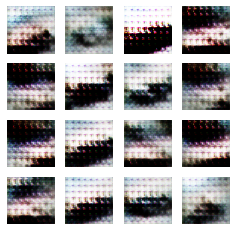

In [ ]:
# Generate a set of sample images from the trained generator model
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :])
plt.axis('off')
plt.show()

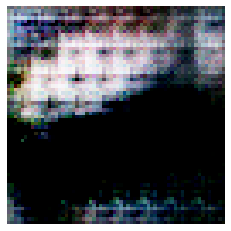